In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor

from lcapt.analysis import make_feature_grid
from lcapt.lca import LCAConv2D
from lcapt.metric import compute_frac_active, compute_l1_sparsity, compute_l2_error
from lcapt.preproc import make_unit_var, make_zero_mean

In [7]:
BATCH_SIZE = 64
EPOCHS = 1
FEATURES = 64  # number of dictionary features to learn
KERNEL_SIZE = 9  # height and width of each feature
LAMBDA = 1.0  # LCA threshold
LCA_ITERS = 1000
PRINT_FREQ = 10
STRIDE = 2  # convolutional stride
TAU = 100  # LCA time constant

In [4]:
dset = CIFAR10("../data", download=True, transform=ToTensor())
dataloader = DataLoader(dset, BATCH_SIZE, shuffle=True, num_workers=4)
for batch_num, (images, _) in enumerate(dataloader):
    print(images.shape)

Files already downloaded and verified
torch.Size([100, 3, 32, 32])
torch.Size([100, 3, 32, 32])
torch.Size([100, 3, 32, 32])
torch.Size([100, 3, 32, 32])
torch.Size([100, 3, 32, 32])
torch.Size([100, 3, 32, 32])
torch.Size([100, 3, 32, 32])
torch.Size([100, 3, 32, 32])
torch.Size([100, 3, 32, 32])
torch.Size([100, 3, 32, 32])
torch.Size([100, 3, 32, 32])
torch.Size([100, 3, 32, 32])
torch.Size([100, 3, 32, 32])
torch.Size([100, 3, 32, 32])
torch.Size([100, 3, 32, 32])
torch.Size([100, 3, 32, 32])
torch.Size([100, 3, 32, 32])
torch.Size([100, 3, 32, 32])
torch.Size([100, 3, 32, 32])
torch.Size([100, 3, 32, 32])
torch.Size([100, 3, 32, 32])
torch.Size([100, 3, 32, 32])
torch.Size([100, 3, 32, 32])
torch.Size([100, 3, 32, 32])
torch.Size([100, 3, 32, 32])
torch.Size([100, 3, 32, 32])
torch.Size([100, 3, 32, 32])
torch.Size([100, 3, 32, 32])
torch.Size([100, 3, 32, 32])
torch.Size([100, 3, 32, 32])
torch.Size([100, 3, 32, 32])
torch.Size([100, 3, 32, 32])
torch.Size([100, 3, 32, 32])
torch

torch.Size([100, 3, 32, 32])
torch.Size([100, 3, 32, 32])
torch.Size([100, 3, 32, 32])
torch.Size([100, 3, 32, 32])
torch.Size([100, 3, 32, 32])
torch.Size([100, 3, 32, 32])
torch.Size([100, 3, 32, 32])
torch.Size([100, 3, 32, 32])
torch.Size([100, 3, 32, 32])
torch.Size([100, 3, 32, 32])
torch.Size([100, 3, 32, 32])
torch.Size([100, 3, 32, 32])
torch.Size([100, 3, 32, 32])
torch.Size([100, 3, 32, 32])
torch.Size([100, 3, 32, 32])
torch.Size([100, 3, 32, 32])
torch.Size([100, 3, 32, 32])
torch.Size([100, 3, 32, 32])
torch.Size([100, 3, 32, 32])
torch.Size([100, 3, 32, 32])
torch.Size([100, 3, 32, 32])
torch.Size([100, 3, 32, 32])
torch.Size([100, 3, 32, 32])
torch.Size([100, 3, 32, 32])
torch.Size([100, 3, 32, 32])
torch.Size([100, 3, 32, 32])
torch.Size([100, 3, 32, 32])
torch.Size([100, 3, 32, 32])
torch.Size([100, 3, 32, 32])
torch.Size([100, 3, 32, 32])
torch.Size([100, 3, 32, 32])
torch.Size([100, 3, 32, 32])
torch.Size([100, 3, 32, 32])
torch.Size([100, 3, 32, 32])
torch.Size([10

In [8]:
lca = LCAConv2D(
    n_neurons=FEATURES,
    in_c=3,
    result_dir="./cifar10_dictionary_learning",
    kh=KERNEL_SIZE,
    kw=KERNEL_SIZE,
    stride_h=STRIDE,
    stride_w=STRIDE,
    lambda_=LAMBDA,
    tau=TAU,
    return_all=False,
    track_metrics=False,
    input_zero_mean=False,
    input_unit_var=False,
)
if torch.cuda.is_available():
    lca = torch.nn.DataParallel(lca).cuda()

In [9]:
for epoch in range(EPOCHS):
    v1_sparsity_distribution_list = []
    v1_activity_distribution_list = []
    v1_fraction_distribution_list = []
    for batch_num, (images, _) in enumerate(dataloader):
        images = make_unit_var(make_zero_mean(images.cuda()))

        code = lca(images)
        v1_activity_distribution_list.append(code)
        v1_fraction_distribution_list.append(compute_frac_active(code))
        v1_sparsity_distribution_list.append(compute_l1_sparsity(code, lca.module.lambda_).item())

        recon = lca.module.compute_recon(code, lca.module.weights)
        lca.module.update_weights(code, recon_error)
        recon_error = images - recon

        if batch_num % PRINT_FREQ == 0:
            l1_sparsity = compute_l1_sparsity(code, lca.module.lambda_).item()
            l2_recon_error = compute_l2_error(images, recon).item()
            total_energy = l2_recon_error + l1_sparsity

            print(
                f"L2 Recon Error: {round(l2_recon_error, 2)}; ",
                f"L1 Sparsity: {round(l1_sparsity, 2)}; ",
                f"Total Energy: {round(total_energy, 2)}",
                f"acts_all: {code.shape}",
                f"batch_num: {batch_num}",
                f"nonzero_counter on activity: {torch.count_nonzero(code)}",
            )

    torch.save(lca, f"../models/Cifar_E{epoch}.pth")

L2 Recon Error: 771.37;  L1 Sparsity: 468.78;  Total Energy: 1240.15 acts_all: torch.Size([100, 64, 16, 16]) batch_num: 0 nonzero_counter on activity: 96293
L2 Recon Error: 311.18;  L1 Sparsity: 447.07;  Total Energy: 758.25 acts_all: torch.Size([100, 64, 16, 16]) batch_num: 10 nonzero_counter on activity: 93328
L2 Recon Error: 249.81;  L1 Sparsity: 404.37;  Total Energy: 654.18 acts_all: torch.Size([100, 64, 16, 16]) batch_num: 20 nonzero_counter on activity: 88040
L2 Recon Error: 214.05;  L1 Sparsity: 361.61;  Total Energy: 575.66 acts_all: torch.Size([100, 64, 16, 16]) batch_num: 30 nonzero_counter on activity: 77935
L2 Recon Error: 196.91;  L1 Sparsity: 347.95;  Total Energy: 544.86 acts_all: torch.Size([100, 64, 16, 16]) batch_num: 40 nonzero_counter on activity: 74404
L2 Recon Error: 184.77;  L1 Sparsity: 334.43;  Total Energy: 519.21 acts_all: torch.Size([100, 64, 16, 16]) batch_num: 50 nonzero_counter on activity: 70338
L2 Recon Error: 169.3;  L1 Sparsity: 320.12;  Total Energy

2D grid here
torch.Size([64, 3, 9, 9])


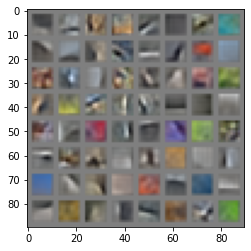

In [10]:
weight_grid = make_feature_grid(lca.module.get_weights())
print(lca.module.get_weights().shape)
plt.imshow(weight_grid.cpu().numpy())

(32, 32, 3) (32, 3)


AttributeError: 'numpy.ndarray' object has no attribute 'cpu'

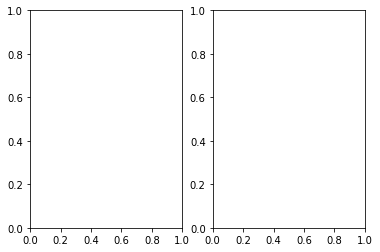

In [12]:
fig, ax = plt.subplots(1, 2)
print(recon.shape, recon[0].shape)
recon_sample = recon[0].cpu().numpy().transpose(1, 2, 0)
print(recon.shape)
recon_error_sample = recon_error[0].cpu().numpy().transpose(1, 2, 0)
inputs_sample = recon_error_sample + recon_sample
recon_sample = (recon_sample - recon_sample.min()) / (recon_sample.max() - recon_sample.min())
inputs = (inputs_sample - inputs_sample.min()) / (inputs_sample.max() - inputs_sample.min())
img1 = ax[0].imshow(inputs_sample)
img2 = ax[1].imshow(recon_sample)
ax[0].set_title("Input")
ax[1].set_title("Reconstruction")

Text(0.5, 1.0, 'Reconstruction')

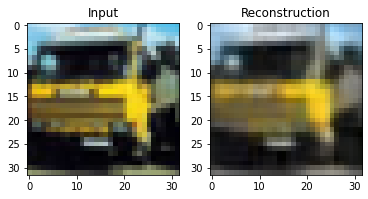

In [60]:
fig, ax = plt.subplots(1, 2)
img1 = ax[0].imshow(inputs)
img2 = ax[1].imshow(recon)
ax[0].set_title("Input")
ax[1].set_title("Reconstruction")

0 [1474.4236    176.01973   212.99086   491.1594     88.28415   146.64365
   56.00742   331.74664   711.83203   224.05997   375.35565  1226.5741
 2786.0425     48.75364    65.29515  1008.715      94.27284    55.91638
  240.3133    646.7241    613.01373   263.4836     25.443243  570.08875
  294.94403    99.76222  1969.3422    317.5621    101.57132    63.623558
   73.98065   889.55475   121.766     392.25638   277.8551   1173.859
   71.094925  493.44876   340.45062    81.226814  479.6955   1225.0543
  565.5294     93.84531   383.3167    111.5628   1174.5475    205.69978
  143.01675   166.16003  1202.901     958.2151    207.92038   415.46317
  171.87389    85.89524   245.09598   189.271     872.9747    285.02612
  173.71774   104.191605 1419.2013   2600.0273  ]
1 [1564.3986    163.17908   212.72313   438.44055    71.55879   132.1075
   51.088585  374.77164   718.9552    254.9612    449.05154  1156.979
 2720.6304     48.1619     48.591232  978.19525   162.19702    50.267967
  212.23502   5

41 [ 472.0694    415.4256    120.7773    489.80298   128.96976   515.8139
  142.44958   200.59174   578.5617    113.20942   260.9711    637.158
 1147.0013     67.3259    108.50919   466.0502    274.6516     77.138855
  299.09985   341.13055   395.1411    172.86038    27.692225  614.85535
  237.00307    58.315422 1621.9132    177.10326    80.475006  149.05003
   58.170708  162.86475   241.75179   100.233116   34.94016  1434.8026
   95.55068   473.30835    20.614058   68.45101   237.67334  1120.9199
  253.39165    61.760094  219.98634    54.369553  194.83615   191.57195
  167.03781   166.38475   804.7051     40.222584   91.56506   370.3178
  160.36458    36.37832   161.00246   127.53959   755.7323    348.26355
   84.06401    78.8305    630.3262   2199.5806  ]
42 [ 443.34137   504.913      72.764496  470.5455    120.01843   454.3018
  137.66177   254.50261   726.2005     77.99986   268.553     659.146
 1205.1309     73.24476   111.68723   476.50436   274.7773     89.73849
  280.09195   31

87 [ 350.1509    590.42505    56.321915  584.20123   143.28542   508.09824
  177.5289    199.00931   758.05066    76.45301   175.862     536.21
  698.71326    77.18513   133.98412   364.0007    329.7293    134.2931
  311.9216    237.95226   453.0401     74.08961    35.107067  248.37369
  172.744      23.571032 1156.5586    232.35106    17.953608  176.45934
   66.35731    97.46081   307.58896   108.479645   35.56994   669.8947
   96.53865   463.3314     48.13678    68.0139    219.2671   1108.8694
  335.34537    48.58418   264.66626    58.41045   220.36069   209.65045
  159.02731   155.48004   348.57922    34.34361    49.169754  137.09991
  148.36911    75.703926  157.67262   130.78377   795.021     345.5874
  104.21377    79.374016  606.9948   1942.0464  ]
88 [ 234.16507   571.517      95.73512   675.0626    148.89792   601.44763
  184.36382    85.91557   568.9457     74.33245   245.67734   549.11597
  740.44244    75.00451   137.96275   361.3587    122.39627   137.41461
  377.07947   2

134 [ 219.10745   556.1873    119.9231    750.84247   167.47372   649.7012
  178.58563   132.07072   415.5864     92.47673   189.6545    369.8284
  528.1841     68.22423   150.77626   273.55664   266.2581    122.86071
  411.17194   113.32998   375.91745   117.60744    58.040295  491.26712
  195.94322    36.591248  805.71423   119.70747    20.928719  245.03511
  112.45677    77.546936  549.4173    119.435715   36.572304  638.44574
  141.11977   442.28568    39.459568   73.04122   349.79126  1135.268
  229.02786    60.727047  301.29044    68.27107   138.07452   297.33426
  193.04778   133.84438   375.19553    42.09284    55.46093   203.84467
   99.073494  173.13678   172.7457    134.02342   339.8944    304.5484
  173.78584   102.19666   488.4343   1673.9448  ]
135 [ 254.38461   536.19653    80.60602   788.6216    106.561455  463.1017
  156.12215   111.67751   762.30206    80.18633   136.56798   422.58054
  617.1246     62.6351    128.06929   223.12323   212.70087   113.44061
  387.21686 

181 [ 296.91568   488.7386     99.07542   694.0421    170.94734   484.05246
  232.00143   160.41277   539.82635    94.43328   171.47862   459.17673
  655.68616    83.1227    165.39658   306.99814   267.44998   133.09999
  401.77924   231.77388   366.40967    59.31714    55.42251   262.7189
  249.77888    29.734812  696.30884   229.39195    26.01823   316.86157
  138.29102    92.83443   510.77795   199.42789    52.341843  471.45477
  155.2069    381.69827    69.84344    86.76828   367.43066   988.33246
  239.4817     51.639435  282.16696   103.40201   166.73859   296.13657
  151.39218   181.64388   221.90544    49.968567   46.255165  123.74892
  145.48793   174.64975   140.53229   140.76294   550.9072    311.89243
  134.0135    144.12825   521.2331   1167.2421  ]
182 [ 251.12332   483.97153    75.95373   709.63025   153.27249   470.0831
  207.7492    184.62862   571.6762     97.6271    146.18541   365.36993
  590.7542     90.57868   160.05096   259.45886   575.7836    108.830086
  377.0

227 [ 260.90872   453.72678   114.21407   801.8748    178.43745   422.88672
  233.39372   149.4889    289.0729    115.64497   193.05676   388.11777
  622.7524    123.130005  193.23877   267.38666   356.10236   159.8029
  353.65945   150.16003   362.4878     76.665504  101.27604   135.35954
  262.5778     28.074142  604.036     159.15427    13.70309   327.64172
  109.4532    162.5351    489.7677    242.16481    67.398605  338.16714
  248.16362   436.7601     86.67014   102.920166  383.66403   890.0691
  282.54703    72.17813   335.0924     91.16612   180.95816   349.8897
  193.91438   161.04436   326.2239     70.1196     57.437244   57.66428
  156.94876   269.70245   243.49146   167.12238   349.62326   333.15045
  173.29726   174.8097    517.36304  1108.9999  ]
228 [ 300.98694   428.57242   103.5675    775.1385    184.84212   404.3492
  210.30234   120.13929   328.93817   111.05852   173.56796   324.84814
  544.73895    81.77964   196.98586   183.46904   255.47758   155.6463
  289.25616

274 [ 262.68106   415.93182   110.51868   740.0664    196.79181   299.65533
  206.24956   160.67188   387.53345   152.2817    167.99196   268.80908
  590.90265    90.788475  254.65775   233.27332   248.18164   168.84929
  331.43787   175.61238   275.67462    70.48282    87.81071   253.67644
  255.11559    37.909008  755.1331    195.72995    51.43997   259.2913
  194.58128   107.64376   469.4157    166.1169     86.17694   364.91058
  162.65372   411.35098    73.56878   100.81689   459.91214   805.9403
  255.48666    96.9534    317.5794    104.22509   173.05397   265.25595
  207.67606   211.31712   282.71313    77.93471   186.40305   188.88028
  210.18001   215.06978   257.07916   177.69397   282.53256   347.40045
  139.70726   150.895     439.88855  1075.2799  ]
275 [311.35956  403.14474   82.54334  637.22504  149.52798  322.74103
 181.55492  170.6034   430.82     110.62559  173.1474   358.38965
 664.193     91.718994 179.80583  242.83989  324.32065  120.86791
 268.202    188.26775  329

320 [227.53683  319.95007  154.06506  763.1649   201.59532  357.8758
 217.52766  142.98407  459.8723   137.87508  232.07524  278.9494
 462.636     91.104454 217.15964  223.66751  264.77277  170.13472
 218.06963  212.96971  298.65643  257.14395  120.033325 374.0827
 229.9163    95.13045  675.5111   197.82274   94.52941  246.54382
 174.7667   166.49072  505.70483  191.32964   72.624084 375.99805
 195.27155  286.20508   88.038635 104.44694  365.1282   727.0052
 167.03975  126.343155 337.80472  173.4078   160.12115  355.07892
 160.63899  195.97012  388.9743    77.837524  98.620544 322.0777
 187.88733  257.60284  251.98355  195.31577  342.31293  297.54834
 173.75743  198.22237  357.0405   843.56525 ]
321 [243.19772  373.9417   120.235405 642.671    193.04921  306.70844
 214.04893  234.6744   401.51556  141.25397  188.72626  367.41934
 539.88855  141.6347   190.70378  261.47498  323.4183   145.33028
 340.15857  206.8997   351.91266   75.19022  110.22291  112.54391
 213.60428   38.590805 625.

367 [254.02654  324.6422   109.53753  703.8015   184.9455   357.20578
 235.93881  117.16621  425.6819   153.53784  210.43985  229.88966
 505.87665   92.78897  224.90283  213.16136  152.51279  137.06938
 299.28644  223.67314  288.49792  145.92566  122.32103  371.05124
 259.35968   95.05722  671.901    221.17986  125.92255  287.53006
 188.43684  152.37009  387.53873  193.09781  101.24897  314.6724
 217.1806   313.7187    68.59822  105.92131  440.81265  583.00085
 258.33087   92.65446  257.16727  146.5009   179.77675  253.99048
 181.22543  185.30022  426.34927   76.81172  107.978195 219.18494
 214.05244  179.38452  300.17227  215.82782  276.5955   321.52493
 140.434    203.38274  440.72156  964.36304 ]
368 [331.57312  403.2214   153.16425  601.83765  194.19562  284.4242
 255.30719  162.48544  351.11978  181.99963  203.4248   280.6055
 504.7985   139.29851  217.07312  256.89078  231.77385  188.15634
 245.5329   178.13164  400.55157  196.03912  135.1023   310.0563
 235.25082  124.4767   529

413 [200.68492 300.30347 130.56465 731.87335 193.26355 304.57828 209.66954
 153.10652 305.3901  152.55771 185.85089 355.30447 562.35645 136.30641
 195.28027 283.22382 256.76624 150.9487  275.54056 184.15474 236.56049
 169.47826 144.19571 188.12267 280.98853  63.20636 546.0597  210.31517
 123.47983 307.9813  194.89325 184.30719 337.0387  161.39798  97.59111
 374.92926 145.6786  307.39276  72.25328  94.8591  327.27658 757.7847
 154.74522 111.41256 298.76657 211.81049 161.41531 328.40912 144.58647
 137.77519 530.78815  85.42975  93.89147 193.52977 203.83209 215.99257
 297.02722 237.42328 260.05167 348.94403 159.15636 174.51357 409.44397
 782.2213 ]
414 [264.18155  358.11588  117.07508  565.96045  176.75047  250.96222
 276.41376  156.00772  620.5868   165.97989  191.03851  199.69592
 470.66254  122.12261  200.69667  246.20708  151.77429  149.9755
 244.56284  276.5845   306.98578  201.97827  127.74534  328.6415
 244.65303   60.33872  594.09326  278.8411   135.41841  391.25665
 182.3486   18

460 [270.43164 275.68872 137.10788 717.1786  144.26057 283.06097 223.15022
 233.93788 405.72293 177.64595 186.2679  311.7516  469.5421  159.22493
 244.18329 202.46684 375.66693 135.36055 253.8797  195.76102 243.75043
 196.70581 120.79651 228.35649 278.4506   87.28754 528.8536  267.1242
 213.8084  307.6338  236.8147  131.74731 355.22107 205.94446 139.22444
 293.5669  188.40244 353.90735  93.35662 100.34912 300.27985 643.599
 268.2181  103.84681 271.545   169.45299 191.79662 297.55396 188.81206
 248.02715 369.1398   68.25861 158.64944 264.6441  220.02563 187.1727
 258.40976 208.76852 381.18283 372.53888 169.72527 136.45535 402.45547
 742.1449 ]
461 [214.19566  295.81827  155.9976   758.2742   210.5721   253.66519
 190.02345  202.61662  175.33955  207.36792  191.25116  314.13043
 565.0581   162.90486  235.448    293.6915   249.05353  161.6771
 261.16208  121.54567  237.16434   89.363914 117.14723  251.4102
 215.92203   52.03553  572.277    146.15012  166.45578  247.43526
  67.42802  155.9

507 [311.2511   288.86572  165.56369  442.6531   211.32042  196.2226
 229.26349  145.71892  541.327    189.19792  199.86288  253.06656
 499.02448  129.71574  222.33148  364.8485   108.468834 205.2949
 302.0146   256.98816  268.92407  106.97998  163.91724  399.39136
 221.61765   69.156235 489.72702  306.26776  205.86763  305.03955
 297.92432  182.47603  316.61694  149.46558  185.23474  298.9885
 154.70476  283.624    103.291    126.682495 316.8781   553.21674
 286.91928  125.872925 254.0499   217.69424  235.32155  289.34613
 199.11485  234.3151   295.6007    92.450836 160.01566  267.92328
 200.24988  189.64467  293.52216  212.65248  336.31873  385.05493
 143.16994  158.18565  414.88077  640.25275 ]
508 [258.1699   331.41644  151.40227  609.9305   165.49196  259.3588
 248.9995   158.21442  277.17792  238.20996  185.96474  334.26978
 472.5373   123.746864 249.6355   342.13254  211.12924  184.1879
 252.98282  151.38948  281.82202  186.2553   117.08592  379.3131
 249.20071  101.38275  570.7

554 [276.68488  234.42293  159.41931  681.97253  138.05887  284.0338
 218.8269   165.9402   263.4717   192.15125  209.02689  334.57706
 519.5396   182.22522  236.70013  314.84592  327.3264   132.98418
 215.88412  191.12727  296.3697   121.97261  150.73506  212.62427
 203.75119   77.48909  570.1747   232.05154  193.91158  287.4953
  58.18394  147.82805  315.23767  170.714    150.48495  389.43604
 160.10269  275.18967  103.418365 132.28693  246.15631  648.9697
 260.65997  141.76523  316.91052  221.75536  162.7737   271.835
 228.15883  215.86353  387.1578    94.560455  79.27615  211.62012
 200.11644  209.33702  360.19067  226.49844  277.3826   375.2776
 165.97968  243.7445   411.8774   755.50903 ]
555 [290.28384  313.6205   168.94617  619.03094  176.81247  196.66235
 235.33467  226.4791   388.66122  244.75941  198.6837   225.4702
 481.8078   175.92293  258.9516   327.2564   178.14781  142.28595
 288.92093  226.47478  280.9423   164.65413  119.7177   228.74638
 252.80159  114.61691  610.99

601 [246.71094  339.8331   207.45702  632.7719   191.26245  231.66965
 227.56038   52.89245  275.0252   237.56702  187.1037   381.76492
 512.8342    88.94254  301.0868   270.64816  142.40613  170.24922
 272.8585   159.8071   253.79611  195.13057  155.82596  408.3571
 297.83948  126.305016 468.33875  207.52744  286.71497  314.36023
  95.549126 221.48087  304.9997   185.72852  111.38997  291.613
 211.9208   276.54892   98.55267  130.62747  291.67377  702.2826
  98.400276 165.29195  336.1209   247.11658  149.90784  315.5812
 162.116    239.14171  371.818    102.48578  101.92863  303.87616
 216.75943  199.21838  275.39188  239.68622  222.166    434.4862
 187.64023  177.56     388.6483   559.1393  ]
602 [307.5088   255.30125  141.4584   517.82513  170.44188  267.4984
 248.4637   191.40466  424.0209   173.14946  229.0243   325.85876
 569.4983   121.05268  230.76581  271.37463  300.26797  176.87248
 298.78296  215.44058  320.17392  121.08577  119.62156  195.00894
 260.76343   75.88654  554.33

647 [189.63876  336.89105  161.23663  657.41003  190.92828  215.99399
 293.14465  152.99118  212.23674  223.37341  130.32495  310.12308
 532.0617   141.403    244.57312  374.405    335.86984  149.39766
 273.7247   164.72868  316.59894   82.21144  205.07018  167.60056
 279.06152   49.988422 625.73737  201.23245  115.473206 385.3219
 146.85294  193.44878  343.27142  228.6144   101.32208  286.05432
 219.51105  324.71173  102.97546  111.5387   243.77095  629.86676
 237.1131   139.19879  272.85928  207.93912  158.01146  234.74527
 167.81804  243.26418  393.67206  102.36919  180.61638  150.03021
 124.707214 203.04564  375.2663   222.33434  228.27618  473.76376
 161.42867  193.7689   460.46085  743.5094  ]
648 [244.7476   318.61105  146.5925   426.80972  170.07156  227.86691
 247.41495  271.08533  318.28748  241.12642  170.7243   264.8504
 599.88257  182.15309  303.57864  342.15372  428.45532  185.65057
 271.47623  162.41364  366.01733  188.5429   187.29507  262.7505
 250.29848   86.60724  52

693 [256.44678  233.3336   159.17702  654.2066   228.32806  187.05081
 250.07875  234.21237  352.10657  196.11574  175.8389   322.98526
 575.9684   286.59583  254.73909  282.98816  389.27182  184.55077
 312.48715  148.63287  227.99088   89.51677  166.23022  123.59646
 227.81921   41.61944  553.3101   263.44272   90.73787  241.63263
 135.49078  188.20879  305.21667  185.44284  175.80464  339.87616
 176.08029  254.56314   96.75575   98.152435 236.49982  639.40906
 407.26196  165.76921  292.08054  220.08804  152.7564   204.43535
 179.57883  178.26027  263.2573   108.82573   87.68156  134.49611
 178.62392  145.3683   422.2471   253.72409  273.48386  424.11386
 149.31029  170.64636  466.68445  682.7477  ]
694 [245.08032  323.1523   237.10359  651.4294   223.28387  253.18411
 240.4709   102.5287   223.38412  196.44547  201.05486  297.04736
 493.0555   125.38457  230.7009   348.19012  251.75159  159.10516
 199.16649  161.80846  257.82642  150.22054  190.55347  146.86865
 217.04129   77.59832 

739 [220.03246  286.8119   213.858    598.3246   231.20892  274.66147
 246.41255  114.25683  210.28705  259.4723   245.18036  299.58496
 544.0261   164.50928  283.50226  280.1746   187.71884  157.7531
 240.27054  200.24417  291.24905  140.06776  169.9013   118.36568
 240.41809   88.30507  426.0917   242.11703  161.16878  257.3989
 221.03079  171.40128  317.22968  203.73824  238.11426  361.185
 216.51178  305.63373  127.04943  135.1643   243.27386  604.37976
 228.1971   157.75397  255.21649  233.69884  176.61647  258.13943
 268.49493  188.78563  359.41718  111.870705 108.080986 245.61026
 192.70872  223.34961  420.70813  270.94858  252.46349  395.94733
 199.09773  290.67392  487.72797  591.31824 ]
740 [244.5111   281.69565  189.69292  708.22906  232.85745  156.64073
 223.0439   209.48651  318.1738   193.80838  198.75627  294.29797
 497.8261   159.26115  234.57393  351.69174  203.56073  199.73508
 297.0978   210.8242   308.15643  135.62943  173.17032  243.59857
 233.78706  119.102905 500

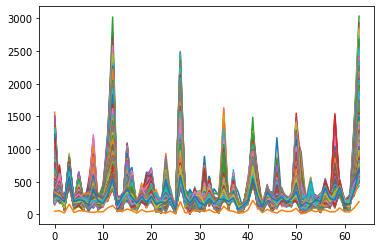

In [25]:
import numpy as np
import pandas as pd


v1_overall_mean_batch64 = []
v1_activity_distribution = []
for ind, v1_activity_batch in enumerate(v1_activity_distribution_list):

    numpy_batch = v1_activity_batch.cpu().numpy()
    batch_mean = numpy_batch.sum(axis=(0, 2, 3))
    v1_overall_mean_batch64.append(batch_mean)
    v1_activity_distribution.append(numpy_batch)
    print(ind, batch_mean, len(batch_mean))
    # plt.figure()
    plt.plot(batch_mean)
    # plt.show()

print(sum(v1_overall_mean_batch64) / len(v1_overall_mean_batch64))
print("batch0 shape: ", v1_activity_distribution_list[0].shape)
# average per batch and overall average from all batches

In [65]:
v1_activity_distribution_array = np.array(v1_activity_distribution)
v1_overall_mean_batch64_array = np.array(v1_overall_mean_batch64)
print(v1_overall_mean_batch64_array[:, n])
v1_overall_mean_batch64_array.shape[0] * v1_overall_mean_batch64_array.shape[1]

/home/gonz495/miniconda3/envs/lca_env/lib/python3.7/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


50048

/home/gonz495/miniconda3/envs/lca_env/lib/python3.7/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


50048


<AxesSubplot:title={'center':'average sparsity: 0.042298984302723205'}, xlabel='neuron'>

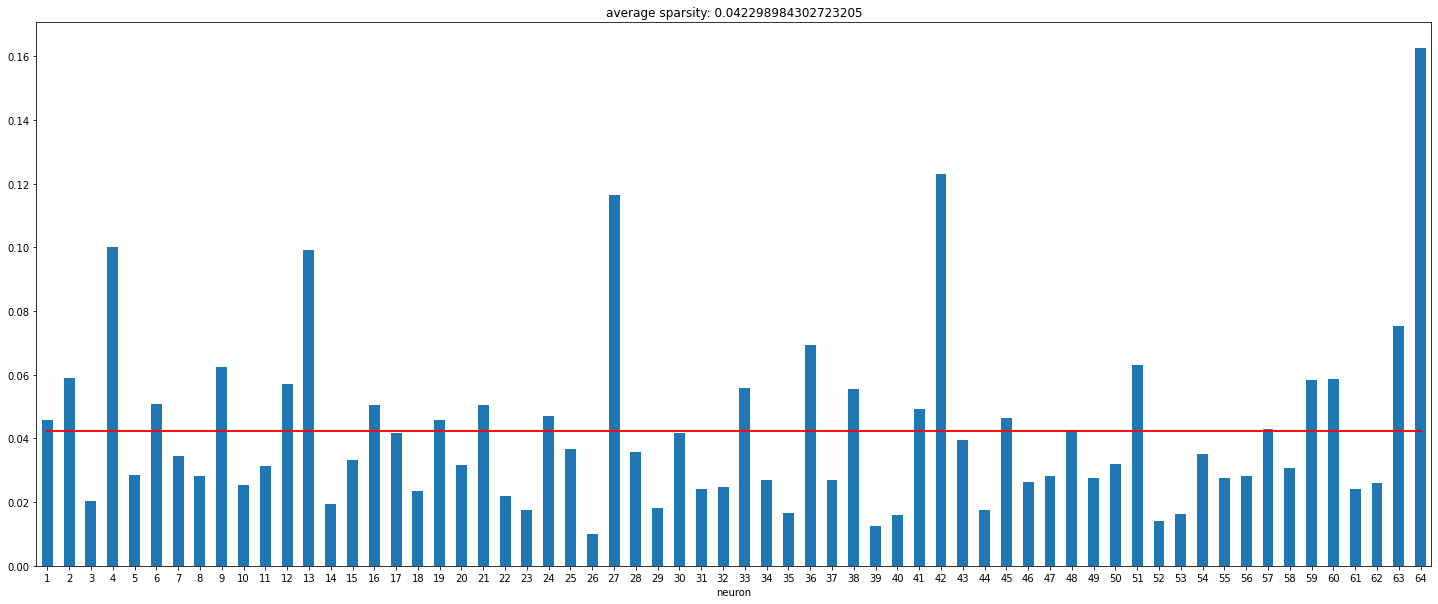

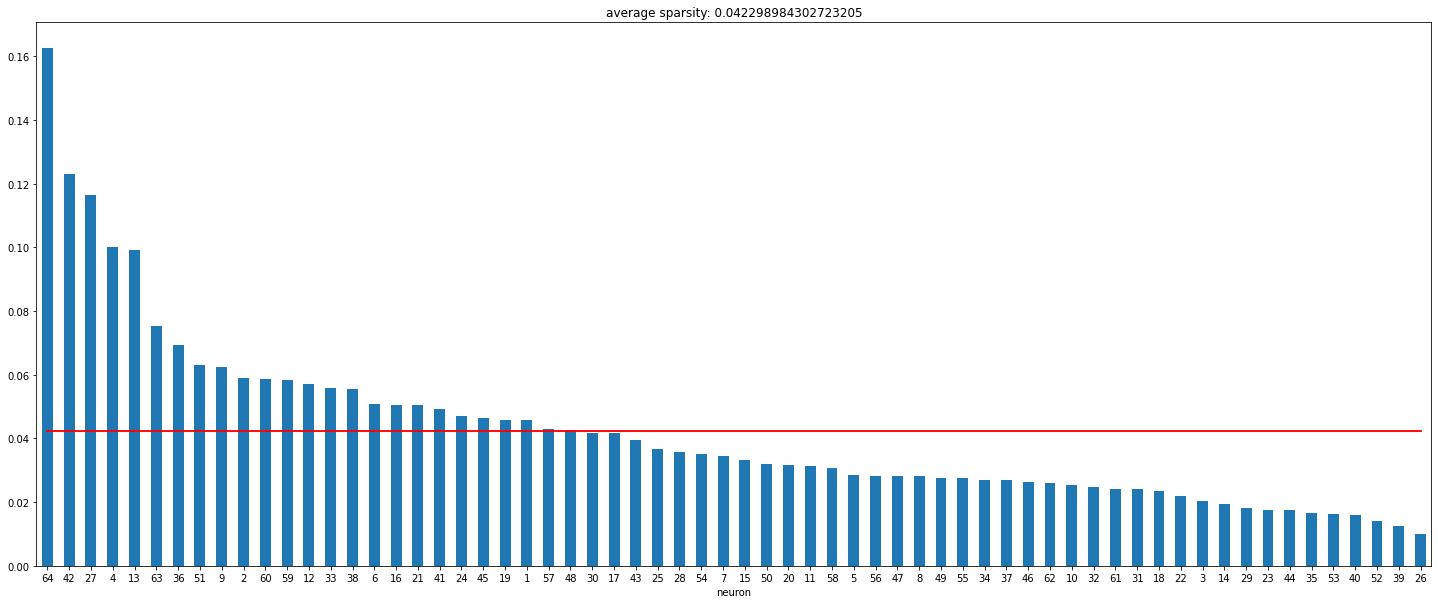

In [83]:
# bool_v1distribution = np.where(v1_activity_distribution > 0, 1, 0)
v1_activity_distribution_array = np.array(v1_activity_distribution)
v1_overall_mean_batch64_array = np.array(v1_overall_mean_batch64)
bool_freq_df = pd.DataFrame(columns=["neuron", "frequency"])

for n in range(v1_overall_mean_batch64_array.shape[1]):
    bool_freq_df.loc[n, "frequency"] = sum(v1_overall_mean_batch64_array[:, n]) / (
        v1_overall_mean_batch64_array.shape[0] * v1_overall_mean_batch64_array.shape[1] * 100
    )

    bool_freq_df.loc[n, "neuron"] = n + 1

mean_sparsity = bool_freq_df["frequency"].mean()
mean_sparsity_df = bool_freq_df * 0 + mean_sparsity
ax1 = bool_freq_df.plot.bar(x="neuron", y="frequency", figsize=(25, 10), legend=False)
mean_sparsity_df.plot(ax=ax1, color="r", title=f"average sparsity: {mean_sparsity}", legend=False)

ax2 = bool_freq_df.sort_values(by=["frequency"], ascending=False).plot.bar(
    x="neuron", y="frequency", figsize=(25, 10), legend=False
)
mean_sparsity_df.plot(ax=ax2, color="r", title=f"average sparsity: {mean_sparsity}", legend=False)

In [72]:
inputs = torch.randn(64, 3, 1, 16, 16)

filters = torch.randn(33, 3, 1, 9, 9)

conv = F.conv3d(inputs, filters)
print(lca.module.weights.shape)
print(inputs.shape)
print(conv.shape)

torch.Size([64, 3, 1, 9, 9])
torch.Size([64, 3, 1, 16, 16])
torch.Size([64, 33, 1, 8, 8])


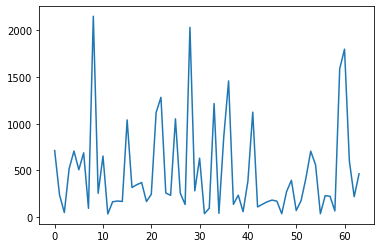

In [75]:
plt.plot(v1_activity_distribution_array[0].sum(axis=(0, 2, 3)))

In [6]:
pd.read_hdf("data/V1 Stimuli/dff.h5")

,frame,repeat,stimulus,session_type,orientation,spatial_frequency,phase,541483910_540168835,541483918_540168835,541483922_540168835,...,589174806_511510911,589174833_511510911,589175052_511510911,589175071_511510911,589175092_511510911,589175111_511510911,589175127_511510911,589175143_511510911,589175164_511510911,589175188_511510911
0,0.0,0.0,natural_movie_one,three_session_B,NaN,NaN,NaN,NaN,NaN,NaN,...,0.045074,0.171143,0.181152,0.088745,0.071289,0.109192,NaN,0.255127,0.090149,NaN
1,1.0,0.0,natural_movie_one,three_session_B,NaN,NaN,NaN,NaN,NaN,NaN,...,0.033051,0.182251,0.136841,0.062805,0.056213,0.094971,NaN,0.181274,0.111023,NaN
2,2.0,0.0,natural_movie_one,three_session_B,NaN,NaN,NaN,NaN,NaN,NaN,...,0.029724,0.166382,0.090942,0.065491,0.059814,0.082947,NaN,0.115601,0.148560,NaN
3,3.0,0.0,natural_movie_one,three_session_B,NaN,NaN,NaN,NaN,NaN,NaN,...,0.044830,0.163452,0.078369,0.085571,0.093445,0.072876,NaN,0.085266,0.098816,NaN
4,4.0,0.0,natural_movie_one,three_session_B,NaN,NaN,NaN,NaN,NaN,NaN,...,0.048370,0.130371,0.049805,0.102844,0.129883,0.130981,NaN,0.053802,0.045868,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186837,NaN,48.3,static_gratings,three_session_B,0.0,0.08,0.50,NaN,NaN,NaN,...,0.044281,0.211792,0.181274,0.172119,0.528809,0.159668,NaN,0.147461,0.097107,NaN
186838,NaN,48.4,static_gratings,three_session_B,0.0,0.08,0.50,NaN,NaN,NaN,...,0.088135,0.189331,0.208984,0.124084,0.491455,0.240356,NaN,0.107483,0.124817,NaN
186839,NaN,48.7,static_gratings,three_session_B,0.0,0.02,0.25,NaN,NaN,NaN,...,0.044891,0.104126,0.118042,0.035370,0.050903,0.079956,NaN,0.110291,0.195801,NaN
186840,NaN,48.7,static_gratings,three_session_B,90.0,0.16,0.50,NaN,NaN,NaN,...,0.059723,0.182617,0.080566,0.123962,0.134277,0.122192,NaN,0.214722,0.115234,NaN


In [23]:
# average per batch and overall average from all batches
# v1_activity_distribution_array[i].sum(axis=(0,2,3))
v1_fraction_distribution = []
v1_overall_mean_frac_batch64 = []
print("batch0 shape: ", len(v1_fraction_distribution_list))
for v1_fraction_batch in v1_fraction_distribution_list:

    numpy_batch = v1_fraction_batch.cpu().numpy()
    batch_mean = numpy_batch.sum(axis=(0, 2, 3))
    v1_fraction_distribution.append(numpy_batch)
    v1_overall_mean_frac_batch64.append(batch_mean)
    # plt.figure()
    plt.plot(batch_mean)
    # plt.show()

print(sum(v1_overall_mean_frac_batch64) / len(v1_overall_mean_frac_batch64))
# average per batch and overall average from all batches

batch0 shape:  782


AttributeError: 'float' object has no attribute 'cpu'

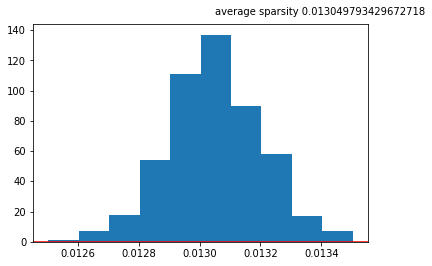

In [77]:
mean_frac_sparsity = sum(v1_fraction_distribution_list) / len(v1_fraction_distribution_list)
plt.text(mean_frac_sparsity, 150, f"average sparsity {mean_frac_sparsity}")
plt.hist(v1_fraction_distribution_list)
plt.axhline(mean_frac_sparsity, color="r")
plt.show()

In [ ]:
(acts != 0.0).float().mean().item()